# CO2 Adsorption Desorption simulation example with a 1D Fixed Bed model
<img src='CO2_Adsorption_Desorption_figure.png' width="300" height="300">

This jupyter notebook shows an example of a CO2 Adsorption Desorption cycle with the IDAES 1D FixedBed model. The IDAES 1D FixedBed model is a dynamic and axially varying reactor/adsorption model which is able to model the gas and solid interactions of the modeled species in detail. The sorbent used for this example is the NETL_32D sorbent with its details and parameters obtained from the following references: 
- A. Lee, D.C. Miller, A One-Dimensional (1-D) Three-Region Model for a Bubbling Fluidized-Bed Adsorber, Ind. Eng. Chem. Res. 52 (2013) 469–484
- Lee, A.; Mebane, D.; Fauth, D. J.; Miller, D. C. A Model for the Adsorption Kinetics of CO2 on Amine-Impregnated Mesoporous Sorbents in the Presence of Water. Presented at the 28th International Pittsburgh Coal Conference, Pittsburgh, PA, 2011.

The notebook demonstrates how to use the IDAES 1DFixedBed model for an adsorption/desorption application with distinct adsorption and desorption steps. This example leverages custom libraries and functions specific to the NETL_32D solid sorbent and associated gas phase properties and surface reactions. In this system, the silicon monoxide (SiO(s)) sorbent reduces carbon dioxide (CO2(g)) to carbamate (denoted Car(s)) while simultaneously absorbing water vapor (H2O(g)) to produce a solid solution-state hydrate (H2O(s)). The solid phase is considered a one-dimensional domain with three regions for bubble, cloud wake and emulsion properties for bubbling bed systems; in the case of a fixed bed reactor non-bulk gas behavior is neglected and assumed to be homogeneous everywhere not near the solid surface.

The notebook also shows how to simulate the adsorption and desorption steps using the PETSc integrator. PETSc leverages nonlinear equation and differential algebraic equation solvers to solve time-trajectory problems. These solvers are applicable for systems with zero degrees of freedom, such as a fully-specified bed reactor model. See https://idaes-pse.readthedocs.io/en/stable/reference_guides/core/solvers.html#petsc-utilities for more details.

## Cycle details
The system contains the following equipment and stream properties:
- Bed height: 9 m
- Bed diameter: 1 m
- Adsorption time: 30 hrs
- Desorption time: 2 hrs
- Adsorption temperature: 303.15 K
- Desorption temperature: 470 K
- Flue gas inlet conditions (Temperature and mole fractions obtained from NETL baseline report. Exhibit 5-22 B31B case)
    - Temperature: 315 K
    - Pressure: 106.5 kPa
    - Flowrate: 3.544 mol/s
    - Mole fractions: CO2: 0.0408, H2O: 0.0875, N2: 0.7517, O2: 0.12

## Notes
Some additional information regarding the problem:
- Isothermal conditions: heat duty requirements of each step are calculated from gas and sorbent properties, i.e., loading, density, heat of adsorption, and heat capacity
- Heating and cooling modes not modeled in detail: cycle times are assumed negligible in comparison to adsorption and desorption
- Adsorption and desorption steps are modeled in different flowsheets
- Initial condition (except temperature) of sorbent in desorption step is set to final condition of sorbent in adsorption step

# Step 1: Import relevant libraries and packages

### Import python libraries

- numpy (numerical python library which provides numerical computing tools)
- time (time python library which will be used to track the simulation time)

In [1]:
import numpy as np
import time


### Import Pyomo pakages
For the flowsheet, we will need several components from the pyomo libraries.

- ConcreteModel (to create the Pyomo model that will contain the IDAES flowsheet)
- TransformationFactory (to apply certain transformations)
- SolverFactory (to solve the problem)
- Var (to create a Pyomo variable)
- value (to return the numerical value of Pyomo objects such as variables, constraints or expressions)
- units (to handle units in Pyomo and IDAES)

For further details on these components, please refer to the pyomo documentation: https://pyomo.readthedocs.io/en/latest/

In [2]:
from pyomo.environ import (
    ConcreteModel,
    TransformationFactory,
    SolverFactory,
    Var,
    value,
    units as pyunits,
)

### Import IDAES core components

To build, initialize, and solve IDAES flowsheets we will need several core components/utilities:

- FlowsheetBlock (the flowsheet block contains idaes properties, time, and unit models)
- EnergyBalanceType (to specify the energy balance type)
- petsc (PETSc integrator)
- get_solver (IDAES solver utility)
- iscale (is used to apply scaling factors in variables and constraints)
- propagate_state (is used to initialize models, propagating the state variables from one unit model to another)
- degrees_of_freedom (useful for debugging, this method returns the DOF of the model)
- idaeslog (is used to set output messages like warnings or errors)

For further details on these components, please refer to the IDAES documentation: https://idaes-pse.readthedocs.io/en/latest/

In [3]:
from idaes.core import FlowsheetBlock, EnergyBalanceType
import idaes.core.solvers.petsc as petsc  # PETSc utilities module
from idaes.core.util import scaling as iscale
from idaes.core.solvers import get_solver
from idaes.core.util.model_statistics import degrees_of_freedom
import idaes.logger as idaeslog
import logging

### Import IDAES unit models and NETL 32D property packages

To build the IDAES flowsheet for the CO2 Adsorption Desorption example, we will need the following: 
1) the 1D Fixed Bed unit model  
2) the NETL 32D property package

In [4]:
from idaes.models_extra.gas_solid_contactors.unit_models.fixed_bed_1D import FixedBed1D
from NETL_32D_gas_phase_thermo import GasPhaseParameterBlock
from NETL_32D_solid_phase_thermo import SolidPhaseParameterBlock
from NETL_32D_adsorption_reactions import HeteroReactionParameterBlock

### Import custom libraries and functions
To simplify and automate this example at the flowsheet level, several custom methods were defined in an external script. The methods are custom, and as such are imported separately from the set of IDAES and Pyomo methods above. These utility functions perform a variety of numerical and reporting tasks:

- heat_computation (used to calculate the heat requirements of the CO2 Adsorption Desorption cycle)
- performance_results (used to evaluate the performance of the CO2 Adsorption Desorption cycle)
- results_summary (provides summarized results of the CO2 Adsorption Desorption cycle)
- plot_results_temporal (plots the temporal profiles of the flowsheet simulation)
- plot_results_spatial (plots the spatial profiles of the flowsheet simulation)
- fb_model_setup (function that builds the 1D FixedBed model)
- fb_fixed_conditions (function that fixes the initial and boundary conditions of the 1D FixedBed model)

In [5]:
from simulation_utilities import (
    heat_computation,
    performance_results,
    results_summary,
    plot_results_temporal,
    plot_results_spatial
)

#### Create a Function to Build the Flowsheet

The function "fb_model_setup" below builds instances of the 1D FixedBed model for the adsorption and desorption simulations. While the effort required to define the reactor is low in terms of lines of code, we will need to do this for both the adsorption and desorption steps. Therefore, defining this setup as a single function will make later steps easier to follow. As arguments it takes the following:
1) The flowsheet block of the simulation, i.e., the adsorption flowsheet  
2) The number of time finite elements  
3) The number of spatial finite elements  

It returns a flowsheet object which contains an instance of the 1D FixedBed model

In [6]:
def fb_model_setup(
    fs,
    ntfe,  # number of time finite elements
    nxfe,  # number of space finite elements
):

    # Set up thermo props and reaction props
    fs.gas_properties = GasPhaseParameterBlock()
    fs.solid_properties = SolidPhaseParameterBlock()

    fs.hetero_reactions = HeteroReactionParameterBlock(
        solid_property_package=fs.solid_properties,
        gas_property_package=fs.gas_properties,
    )

    fs.FB = FixedBed1D(
        finite_elements=nxfe,
        transformation_method="dae.finite_difference",
        energy_balance_type=EnergyBalanceType.none,
        pressure_drop_type="ergun_correlation",
        gas_phase_config={"property_package": fs.gas_properties},
        solid_phase_config={
            "property_package": fs.solid_properties,
            "reaction_package": fs.hetero_reactions,
        },
    )

    # Discretize time domain
    fs.discretizer = TransformationFactory("dae.finite_difference")
    fs.discretizer.apply_to(fs, nfe=ntfe, wrt=fs.time, scheme="BACKWARD")

    return fs

#### Create a Function to Fix the Flowsheet Conditions

The function "fb_fix_conditions" fixes the initial and boundary conditions of an instance of the 1D FixedBed model. It also has checks to ensure that the degrees of freedom are zero, and that the velocity into the bed is less than the minimum fluidization velocity of the bed. Similarly to the function above, we will need to run this for the adsorption and desorption steps, and it is clearer to define the code once as a single function here. As arguments it takes the following:
1) The flowsheet block of the simulation, i.e., the adsorption flowsheet  
2) The reactor bed diameter  
3) The reactor bed height  
4) A dictionary of gas phase state data for which the gas phase state variables of the model should be fixed to  
5) A dictionary of solid phase state data for which the solid phase state variables of the model should be fixed to. If None, the solid phase state variables are fixed to their current values.  

No object is returned by this function.

In [7]:
def fb_fix_conditions(
    fs, bed_diameter, bed_height, gas_phase_state_dict, solid_phase_state_dict=None
):
    # Fix bed geometry variables
    fs.FB.bed_diameter.fix(bed_diameter)  # m
    fs.FB.bed_height.fix(bed_height)  # m

    # Fix boundary values for gas for all time
    blk = fs.FB
    for t in fs.time:
        # Gas values
        blk.gas_inlet.flow_mol[t].fix(gas_phase_state_dict["flow_mol"])
        blk.gas_inlet.temperature[t].fix(gas_phase_state_dict["temperature"])
        blk.gas_inlet.pressure[t].fix(gas_phase_state_dict["pressure"])
        for j, val in gas_phase_state_dict["mole_frac_comp"].items():
            blk.gas_inlet.mole_frac_comp[t, j].fix(val)

    # Specify gas phase and solid phase initial conditions for all space
    t0 = fs.time.first()
    for x in blk.length_domain:
        blk.gas_phase.properties[t0, x].flow_mol.fix(gas_phase_state_dict["flow_mol"])
        blk.gas_phase.properties[t0, x].temperature.fix(
            gas_phase_state_dict["temperature"]
        )  # K
        for j, val in gas_phase_state_dict["mole_frac_comp"].items():
            blk.gas_phase.properties[t0, x].mole_frac_comp[j].fix(val)

        if solid_phase_state_dict is None:
            # Fix to existing values if dict is empty
            blk.solid_properties[t0, x].dens_mass_particle.fix()
            blk.solid_properties[t0, x].temperature.fix()
            blk.solid_properties[t0, x].mass_frac_comp[:].fix()
        else:
            blk.solid_properties[t0, x].dens_mass_particle.fix(
                solid_phase_state_dict["dens_mass_particle"]
            )
            blk.solid_properties[t0, x].temperature.fix(
                solid_phase_state_dict["temperature"]
            )
            for j, val in solid_phase_state_dict["mass_frac_comp"].items():
                blk.solid_properties[t0, x].mass_frac_comp[j].fix(val)

    dof = degrees_of_freedom(fs)

    print("degrees of freedom = ", dof)
    try:
        assert degrees_of_freedom(fs) == 0
    except AssertionError:
        print('Degrees of freedom is not equal to zero. This is unexpected.')
        raise

    # Assert that inlet gas velocity is less than v_mf
    # Use solid temperature as the thermal mass of solid >> than that of gas
    pi = 3.14  # [-]
    R = 8.314  # Gas constant [J/mol/K]

    @blk.Expression(doc="gas inlet velocity, m/s")
    def gas_inlet_velocity(blk):
        v_gas_inlet = (
            blk.gas_inlet.flow_mol[0] / (pi * value(blk.bed_diameter ** 2) / 4)
        ) * (R * blk.solid_properties[0, 0].temperature / blk.gas_inlet.pressure[0])
        return v_gas_inlet

    v_mf = value(  # minimum fluidization velocity [m/s]
        blk.solid_properties[t0, 0]._params.velocity_mf
    )
    print("inlet gas velocity = ", value(blk.gas_inlet_velocity), ' m/s')
    print("min. fluid velocity = ", v_mf, ' m/s')
    try:
        assert value(blk.gas_inlet_velocity) <= v_mf
    except AssertionError:
        print('The inlet gas velocity is greater than the minimum fluidization velocity. '
              'This is unexpected for a Fixed Bed.')
        raise

# Step 2: Setup and run simulation
Now that the system properties and all required utility functions are defined, we will build the model itself.

#### Create concrete model
First, create the model object:

In [8]:
m = ConcreteModel()

#### Setup solver for initialization
We add a bound push to ensure the initial is not too close to the end of the domain. In this case, we allow the initial point to move 1e-22 inside the bounds if necessary to stabilize the problem. Users still need to provide a good initial point, and having a large bound push will not compensate for a bad initial point.

In [9]:
# Solver arguments
optarg = {
    "max_iter": 100,
    "nlp_scaling_method": "user-scaling",
    "linear_solver": "ma27",
}

# Create a solver
solver = get_solver("ipopt")
solver.options = optarg

#### Set spatial elements and design variables for adsorption and desorption simulations
Let's define the size of the system:

In [10]:
# Number of spatial elements
nxfe = 50

# Design variables for static and dynamic models
bed_diameter = 9  # m
bed_height = 1  # m

## Adsorption simulation
First, we will run the adsorption step by defining the simulation domain, add initial conditions, and set up and solve the model.

### Setup simulation horizon and create time set
We specify the time discretization to an exact set of temporal points according to the problem horizon:

In [11]:
# Time horizon
horizon = 108000  # s

# Create time_set list
t_element_size = horizon / 4  # s
ntfe = int(horizon / t_element_size)
time_set = list(np.linspace(0, horizon, ntfe + 1))

### Initial conditions for gas and solid phases
Next, we set reasoanble initial conditions for the gas and solid phases at time = 0, with a constant adsorption temperature:

In [12]:
# Flue gas inlet conditions to adsorption system (flue gas stream) -
# Temperature and mole fractions obtained from NETL baseline report.
# Exhibit 5-22 B31B case.
adsorption_temperature = 303.15  # K

# Dictionary of initial and boundary conditions for gas phase
gas_phase_state_dict_ads = {
    "flow_mol": 3.544,  # mol/s
    "temperature": adsorption_temperature,  # K
    "pressure": 1.2452e5,  # Pa
    "mole_frac_comp": {  # [-]
        "CO2": 0.0408,
        "H2O": 0.0875,
        "N2": 0.7517,
        "O2": 0.12,
    },
}

# Dictionary of initial conditions for solid phase
solid_phase_state_dict_ads = {
    "dens_mass_particle": 442,  # kg/m3
    "temperature": adsorption_temperature,  # K
    "mass_frac_comp": {  # [-]
        "H2O_s": 1e-8,
        "Car": 1e-8,
        "SiO": 1,
    },
}

### Setup the adsorption model
Then, we call our previously defined methods to build the model and fix initial conditions:

In [13]:
# Create the adsorption flowsheet
m.fs_ads = FlowsheetBlock(dynamic=True, time_set=time_set, time_units=pyunits.s)

# Setup an instance of the 1D FixedBed model for the adsorption simulation
m.fs_ads = fb_model_setup(m.fs_ads, ntfe, nxfe)

# Fix initial and boundary conditions
fb_fix_conditions(
    m.fs_ads,
    bed_diameter,
    bed_height,
    gas_phase_state_dict_ads,
    solid_phase_state_dict_ads,
)

degrees of freedom =  0
inlet gas velocity =  0.0011281517419625495  m/s
min. fluid velocity =  0.0091  m/s


###  Adsorption model - initialize and solve
Finally for the adsorption model, we initialize and solve.

#### Apply scaling transformation
We first scale the model variables and equations to reduce ill-conditioning and improve its convergence properties:

In [14]:
iscale.calculate_scaling_factors(m.fs_ads)

#### Initialize model
The model initialization is done with the block triangularization initialization method in the 1D FixedBed model as this is faster than using the traditional sequential heirarchichal initialization approach. See the 1D FixedBed model and documentation for more details on this method.

In [15]:
# Run start time
t_start_ads = time.time()

# Initialize model
calc_var_kwds = {"eps": 1e-5}
m.fs_ads.FB.block_triangularization_initialize(
    gas_phase_state_args=gas_phase_state_dict_ads,
    solid_phase_state_args=solid_phase_state_dict_ads,
    outlvl=idaeslog.DEBUG,
    solver=solver,
    calc_var_kwds=calc_var_kwds,
)

# Run end time
t_end_ads = time.time()

# Initialization time
adsorption_initialization_time = value(t_end_ads - t_start_ads)

#### PETSc integrator
As mentioned earlier, the PETSc integrator is used for simulating the time trajectory. After starting the clock and instantiating the time variables, PETSc performs and element-wise discretization to define and solve the dynamic system of equations. See https://idaes-pse.readthedocs.io/en/stable/reference_guides/core/solvers.html#petsc-utilities for more details.


In [16]:
petscsolvelog = idaeslog.getSolveLogger("petsc-dae")
petscsolvelog.setLevel(logging.WARNING)  # comment this line to see PETSc solver output

# Run start time
t_start_ads = time.time()

# Setup PETSc integrator and simulate adsorption flowsheet
m.fs_ads.time_var = Var(m.fs_ads.time)
m.fs_ads.time_var[0].fix(m.fs_ads.time.first())

result_ads = petsc.petsc_dae_by_time_element(
    m.fs_ads,
    time=m.fs_ads.time,
    timevar=m.fs_ads.time_var,
    keepfiles=True,
    symbolic_solver_labels=True,
    skip_initial=False,
    ts_options={
        "--ts_type": "beuler",  # backward euler integration
        "--ts_dt": 200,  # set initial step to 200
        "--ts_rtol": 20,
        "--ts_monitor": "",
        "--ts_save_trajectory": 1,
        "--ksp_rtol": 1e-10,
        "--snes_type": "newtontr",  # newton trust region non-linear solver
        "--ts_monitor": "",
        "--ts_save_trajectory": 1,
        "--ts_max_snes_failures": 1000,
    },
)
tj_ads = result_ads.trajectory  # trajectory data

# Run end time
t_end_ads = time.time()

# Initialization time
adsorption_simulation_time = value(t_end_ads - t_start_ads)

###  Plot the adsorption simulation results
After running the adsorption simulation, the dynamic profiles are plotted.

In the temporal plots below, quantities are reported as functions of time and contoured for six points along the length of the bed. The time and spatial dimensions are exchanged in the spatial plots, with quantities reported as functions of lengh and contoured for five time points.

The gas flowrate is constant at the inlet and decreases over the length of the bed as CO2 is removed from the gas. At each spatial point, the CO2 content of the gas increases over time as the bed becomes more saturated with CO2 and the mass transfer driving force decreases. Assessing the two gas flowrate plots, adsorption occurs steadily over time with a much larger capture rate in the initial spatial region; this region grows from 10% to 25% of the bed length as the bed becomes more saturated with CO2 over time.

The bed pressure stays relatively constant over time, and exhibits a linear drop over the length of the reactor. There are no temporal or spatial gradients in gas or solid temperature.

The saturation trend is strongly apparent in the composition trends. The CO2 content of the gas quickly drops from the initial concentration over the length of the bed, and steadily rises over time as the driving force of mass transfer decreases. Water vapor concentration in the gas follows a similar trend.

Following the solid-state reaction, the concentration of carbmate steadily increases over time with formation skewing heavily towards the initial spatial region of the bed. The spatial contours of the temporal carbamate composition plot cross as a result of the solid reaction rate heavily favoring the initial section of the bed and suddenly dropping about at about 20% of the reactor length. The mass fraction and mol/kg plots differ slightly due to water and CO2 absorbing at different rates, but otherwise demonstrate similar trends.

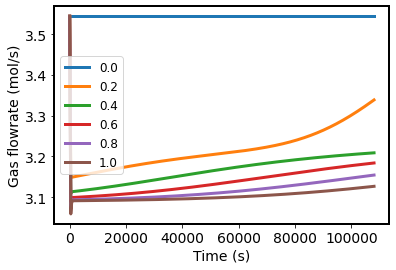

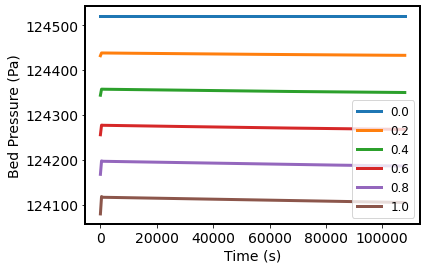

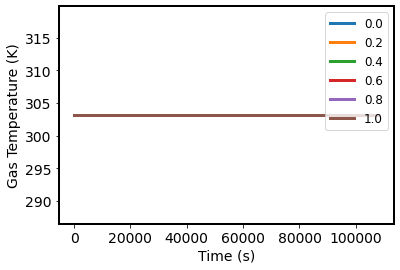

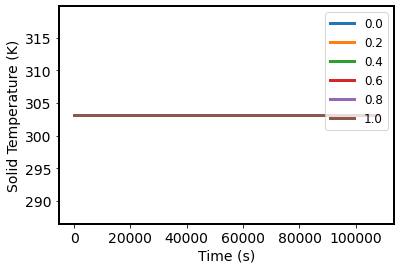

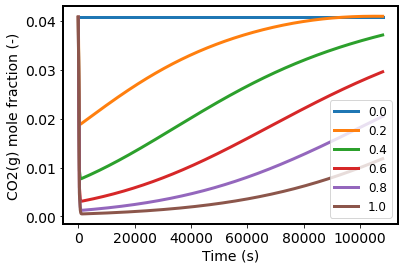

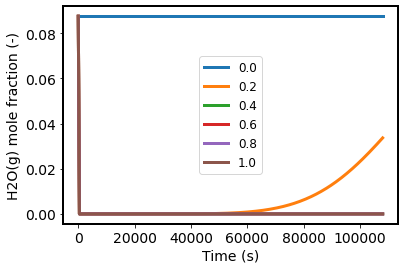

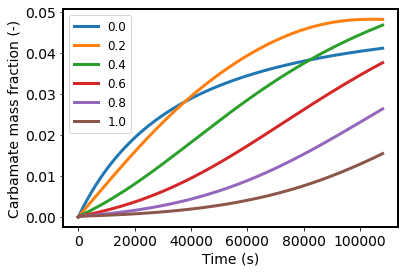

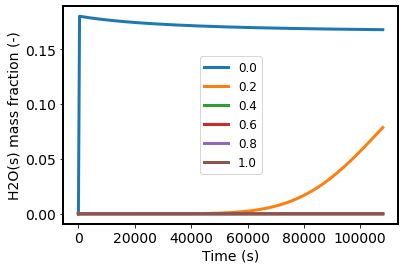

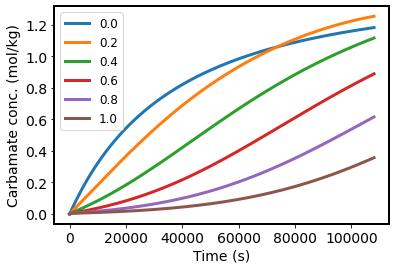

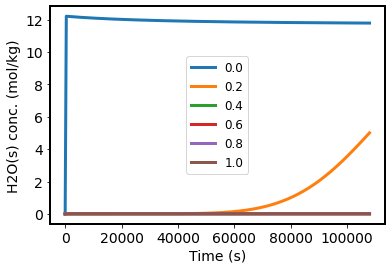

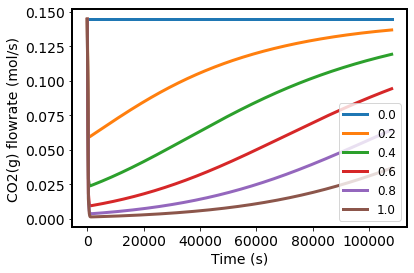

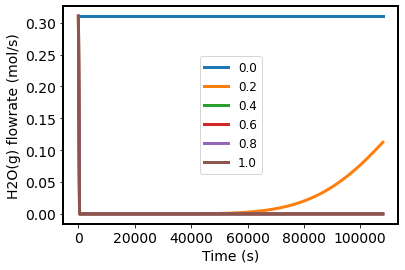

In [17]:
# Plot temporal result profiles
plot_results_temporal(m.fs_ads, tj_ads)

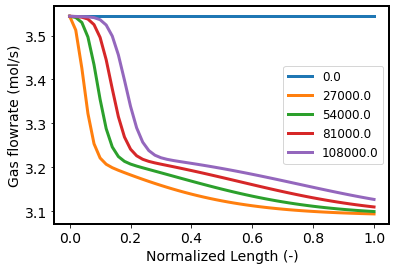

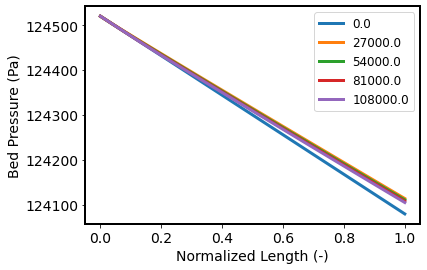

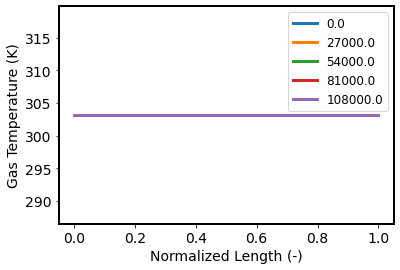

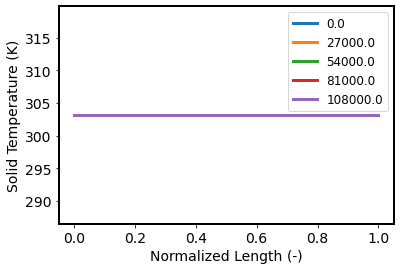

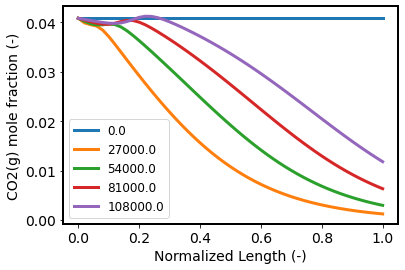

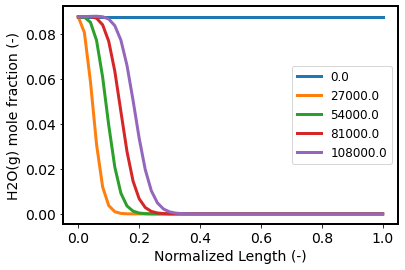

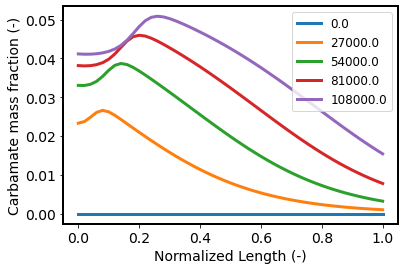

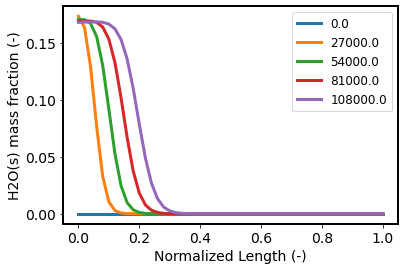

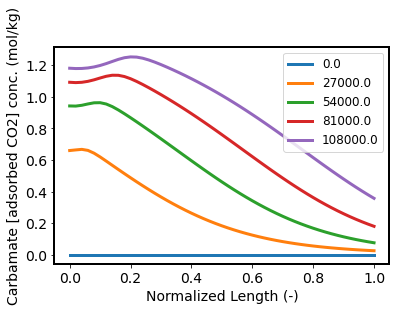

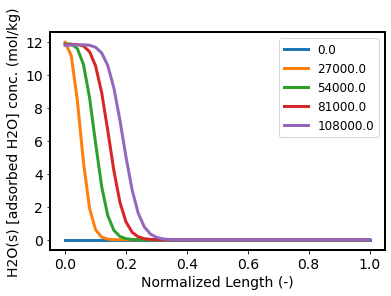

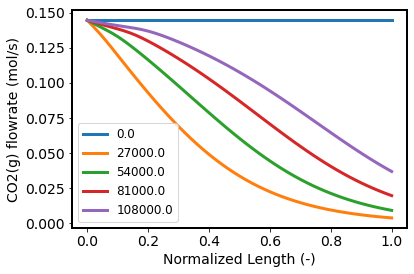

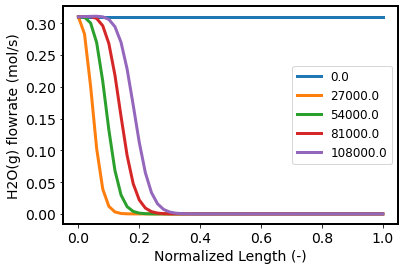

In [18]:
# Plot spatial result profiles
plot_results_spatial(m.fs_ads, tj_ads)

## Desorption simulation
The desorption simulation begins when the adsorption simulation ends. It uses the final state of the sorbent (besides temperature which is set at the desorption temperature) in the adsorption mode as the initial state of the sorbent in the desorption mode.

### Setup simulation horizon and create time set
As in the adsorption simulation, we first specify the time discretization:

In [19]:
# Space and time discretization arguments
horizon = 7200  # s

# Setup for PETSc run
t_element_size = horizon  # s
ntfe = int(horizon / t_element_size)
time_set = list(np.linspace(0, horizon, ntfe + 1))

### Initial and boundary conditions for gas phase
- The initial conditions of the solid phase will be copied from the final conditions of the model in the adsorption simulation.

In [20]:
# Desorption operating conditions
desorption_temperature = 470  # K

gas_phase_state_dict_des = {
    "flow_mol": 10,  # mol/s
    "temperature": desorption_temperature,  # K
    "pressure": 1.06525e5,  # Pa
    "mole_frac_comp": {"CO2": 1e-8, "H2O": 1, "N2": 1e-8, "O2": 1e-8},  # [-]
}

### Setup the desorption model
Then, we build the model and fix initial conditions:

In [21]:
# Create the desorption flowsheet
m.fs_des = FlowsheetBlock(dynamic=True, time_set=time_set, time_units=pyunits.s)

In [22]:
# Setup an instance of the 1D FixedBed model for the desorption simulation
m.fs_des = fb_model_setup(
    m.fs_des,
    ntfe,
    nxfe,
)

###  Desorption model - initialize and solve
Finally for the desorption model, we initialize and solve.

##### Copy values from adsorption model to desorption model
Copy state values of solid phase (besides temperature) from last time point in adsorption model to all time point in desorption model. Also set temperature state variable of desorption model to desorption temperature.

In [23]:
blk_des = m.fs_des.FB
tf_ads = tj_ads.time[-1]  # Get final time from adsorption trajectory results
tf_ads_index = tj_ads.time.index(tf_ads)  # Get index at final time
component_list = blk_des.config.solid_phase_config.property_package.component_list

for t in m.fs_des.time:
    for x in blk_des.length_domain:
        blk_des.solid_properties[t, x].temperature.set_value(desorption_temperature)
        blk_des.solid_properties[t, x].dens_mass_particle.set_value(
            tj_ads.get_vec(
                m.fs_ads.FB.solid_properties[tf_ads, x].dens_mass_particle
            )[tf_ads_index]
        )
        for j in component_list:
            blk_des.solid_properties[t, x].mass_frac_comp[j].set_value(
                value(
                    tj_ads.get_vec(
                        m.fs_ads.FB.solid_properties[tf_ads, x].mass_frac_comp[j]
                    )[tf_ads_index]
                )
            )


#### Fix initial and boundary conditions
We fix the conditions from the final adsorption model state as our new initial conditions for the desorption model:

In [24]:
fb_fix_conditions(
    m.fs_des,
    bed_diameter,
    bed_height,
    gas_phase_state_dict_des,
)

degrees of freedom =  0
inlet gas velocity =  0.00576901488631887  m/s
min. fluid velocity =  0.0091  m/s


#### Calculate scaling of desorption model
Then, we apply scaling to the model:

In [25]:
iscale.calculate_scaling_factors(m.fs_des)

#### Initialize desorption model
The desorption model initialization is done with the block triangularization initialization method, as was done with the adsorption model.

In [26]:
# Run start time
t_start_des = time.time()

# Initialize model
m.fs_des.FB.block_triangularization_initialize(
    gas_phase_state_args=gas_phase_state_dict_des,
    outlvl=idaeslog.DEBUG,
    solver=solver,
    calc_var_kwds=calc_var_kwds,
)

# Run end time
t_end_des = time.time()

# Initialization time
desorption_initialization_time = value(t_end_des - t_start_des)

#### Setup PETSc integrator and simulate desorption step
Now that the model is fully defined, we can call the PETSc integrator to simulate the dynamics of the problem:

In [27]:
# Run start time
t_start_des = time.time()

# Setup PETSc integrator and simulate desorption flowsheet
m.fs_des.time_var = Var(m.fs_des.time)
m.fs_des.time_var[0].fix(m.fs_des.time.first())

result_des = petsc.petsc_dae_by_time_element(
    m.fs_des,
    time=m.fs_des.time,
    timevar=m.fs_des.time_var,
    keepfiles=True,
    symbolic_solver_labels=True,
    skip_initial=False,
    ts_options={
        "--ts_type": "beuler",  # backward euler integration
        "--ts_dt": 200,  # set initial step to 200
        "--ts_rtol": 20,
        "--ts_monitor": "",
        "--ts_save_trajectory": 1,
        "--ksp_rtol": 1e-10,
        "--snes_type": "newtontr",  # newton trust region non-linear solver
        "--ts_monitor": "",
        "--ts_save_trajectory": 1,
        "--ts_max_snes_failures": 1000,
    },
)
tj_des = result_des.trajectory  # trajectory data

# Run end time
t_end_des = time.time()

# Initialization time
desorption_simulation_time = value(t_end_des - t_start_des)

###  Plot the desorption simulation results
Similar to the results of the adsorption model, the plots below are presented as temporal plots with spatial contours and spatial plots with time contours to fully capture the model trends.

The gas flowrate spikes initially as large quantities of CO2 are recovered, and then the flowrate drops rapidly as the CO2 is carried away. An interesting note is that this occurs over the same time period everywhere across the length of the bed, peaking around 1000 seconds into the simulation. In the spatial plot, the peak is missed between the first and second contours; instead, the spatial plots captures a similar shifting inflection point around 10-25% of the way into the bed as the mass transfer driving force suddenly decreases.

The bed pressure drops suddenly as CO2 is initially desorbed from the bed, and a steady state is reached at larger time points. As in the adsorption case, the desorption results show no temporal or spatial gradients in gas or solid temperature.

The CO2 content of the gas sharply rises initially, and steadily decreases as CO2 is carried away in the sweep gas. A greater amount of CO2 is recovered closer to the reactor inlet. As the sweep gas is nearly pure water vapor, the water concentration in the gas sharply drops as CO2 is desorbed from the bed and recovers to near unity towards the temporal end of the simulation.

Carbamate disappears quickly as CO2 is recovered and the hydrate is broken down, occuring evenly across the length of the reactor bed.

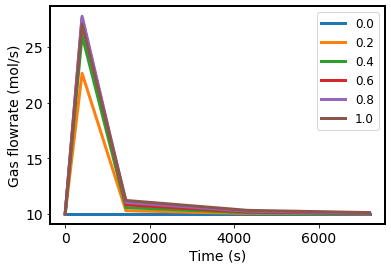

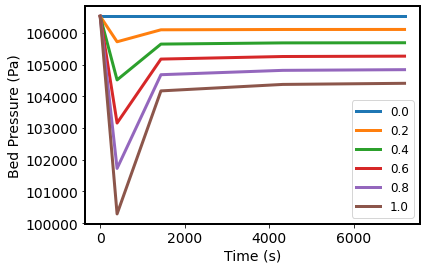

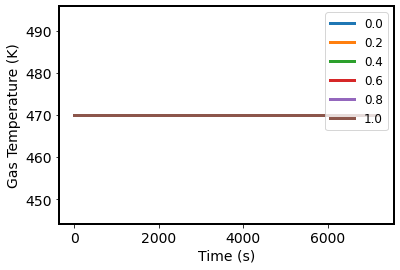

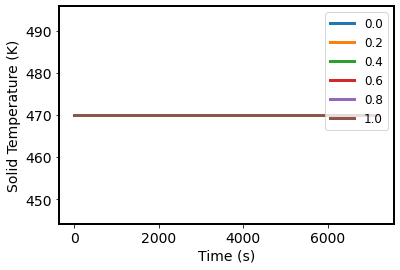

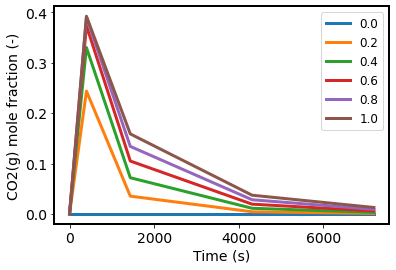

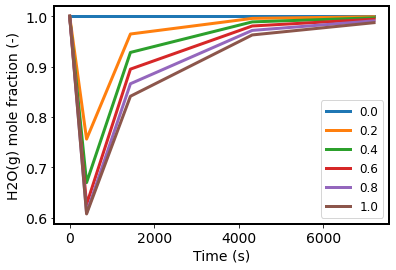

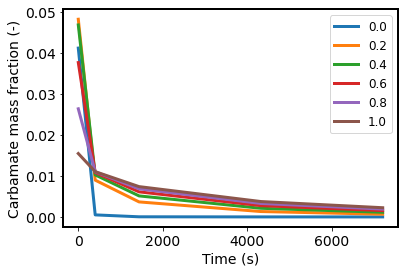

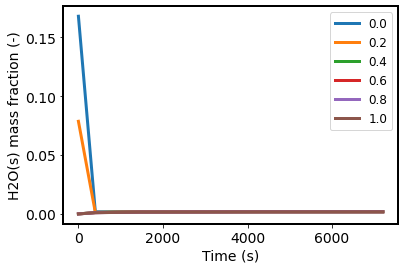

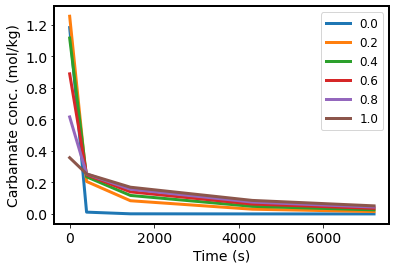

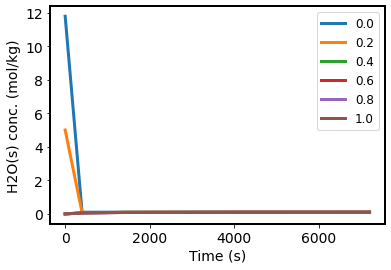

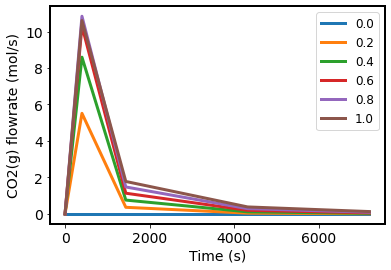

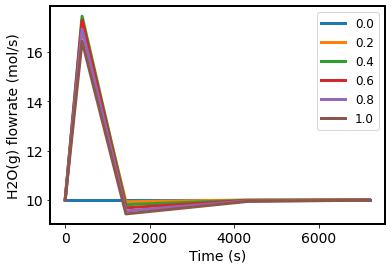

In [28]:
# Plot temporal result profiles
plot_results_temporal(m.fs_des, tj_des)

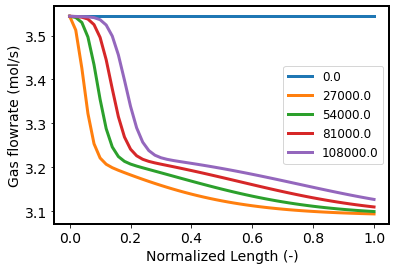

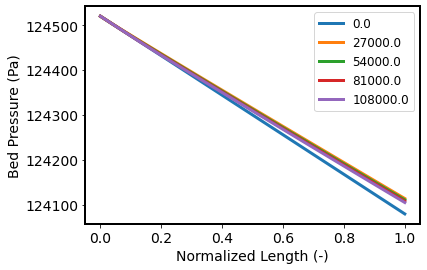

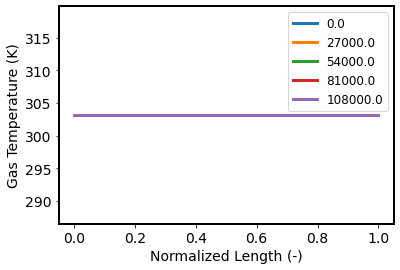

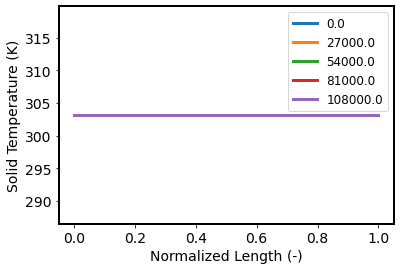

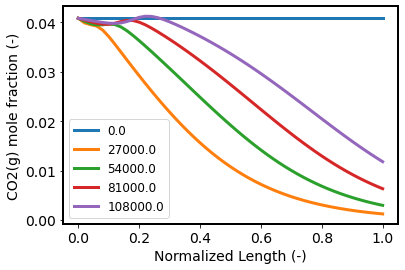

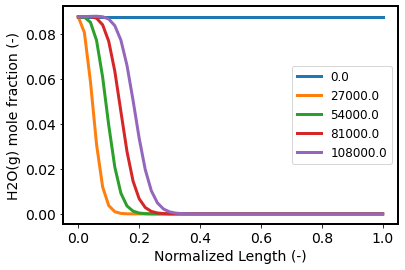

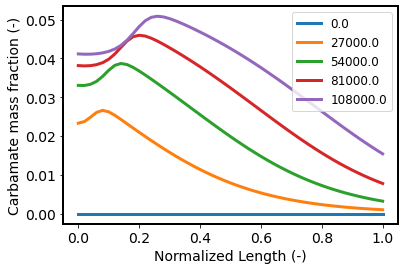

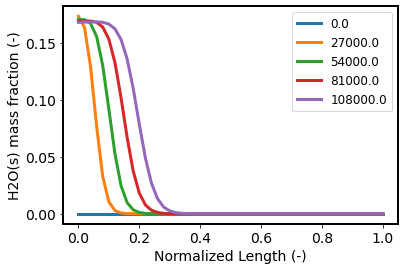

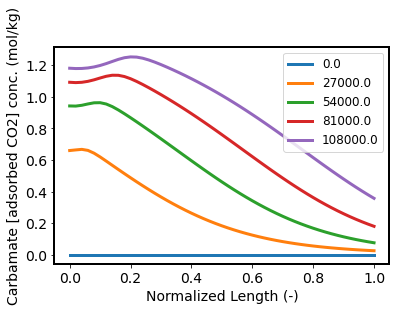

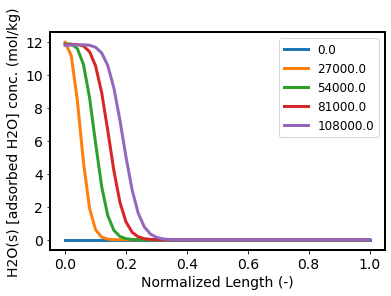

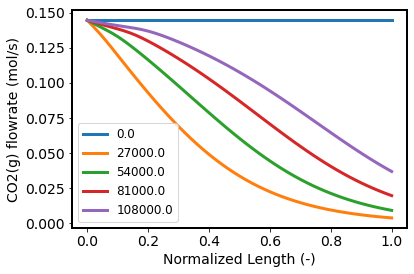

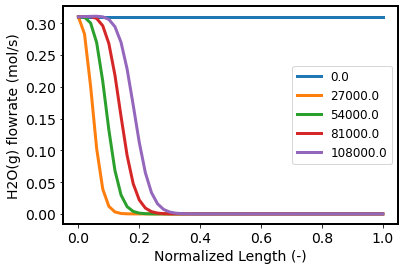

In [29]:
# Plot spatial result profiles
plot_results_spatial(m.fs_ads, tj_ads)

## Step 3: Generate performance results

In [30]:
###########################################################################
#  Heat requirements
###########################################################################
heat_computation(
    m, tj_ads, tj_des, adsorption_temperature, desorption_temperature
)

    taken
    taken
    taken


In [31]:
###########################################################################
#  Performance results
###########################################################################
performance_results(m, tj_ads, tj_des)

results_summary(m, adsorption_temperature, desorption_temperature)


Report fixed bed adsorption/desorption

Adsorption temperature [K]: 303.1500
Desorption temperature [K]: 470.0000
Column diameter [m]: 9.0000
Column length [m]: 1.0000
CO2 mole fraction at feed [%]: 4.0800
Feed flow rate [mol/s]: 3.5440
Feed velocity [m/s]: 0.0011
Minimum fluidization velocity [m/s]: 0.0091
Time of adsorption step [h]: 30.0000
Time of desorption step [h]: 2.0000
Cycle time [h]: 32.0000
CO2 input per cycle [kg/bed/cycle]: 687.1164
CO2 released per cycle [kg/bed/cycle]: 60.9462
CO2 adsorbed per cycle [kg/bed/cycle]: 632.8896
CO2 desorbed per cycle [kg/bed/cycle]: 612.9607
Purity [-]: 0.2150
Recovery [-]: 0.9685
Productivity [kg CO2/ton/h]: 979.7350
Specific energy [MJ/kg CO2]: 1.4651
Heat duty per bed [MW]: 0.1247
Cooling duty per bed [MW]: -0.0257
CO2 adsorbed per cycle CO2 balance [kg/bed/cycle]: 626.1702
CO2 adsorbed per cycle carbamate balance [kg/bed/cycle]: 632.8896
CO2 desorbed per cycle CO2 balance [kg/bed/cycle]: 1189.9358
CO2 desorbed per cycle carbamate balan

## Simulation time results

In [32]:
print('Adsorption initialization time: ', adsorption_initialization_time, ' s')
print('Adsorption simulation time: ', adsorption_simulation_time, ' s')
print()
print('Desorption initialization time: ', desorption_initialization_time, ' s')
print('Desorption simulation time: ', desorption_simulation_time, ' s')
print()
total_simulation_time = (adsorption_initialization_time + adsorption_simulation_time
                         + desorption_initialization_time + desorption_simulation_time)
print('Total simulation time: ', total_simulation_time, ' s')

Adsorption initialization time:  13.401541709899902  s
Adsorption simulation time:  379.34459376335144  s

Desorption initialization time:  6.139604806900024  s
Desorption simulation time:  10.704358339309692  s

Total simulation time:  409.59009861946106  s


# Summary
This example demonstrates implementation of the 1D FixedBed model within IDAES. External property packages for multiple phase domains and interfaces, as well as mass transfer and reaction properties, were integrated into two simulations. The simulations are connected via their final (adsorption) and initial (desorption) states, and each utilizes the PETSc integrator to calculate temporal profiles over the spatial domains.